In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# earthquakes detected in the Parkfield region from 1950 to 2016.
# The magnitudes of all earthquakes in the region from the ANSS ComCat.
data_eq = pd.read_csv('parkfield_earthquakes_1950-2017.csv')
data_eq.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
0,1951-10-03 13:44:33.170,35.869333,-120.451000,6.0,3.67,ml,6.0,259.0,1.5480,0.43,...,31.61,0.154,10.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
1,1953-05-28 07:58:34.510,36.004167,-120.501167,6.0,3.61,ml,7.0,296.0,0.9139,0.39,...,31.61,NaN,1.0,reviewed,ci,ci,Coalinga,California,Fresno County,US
2,1961-12-14 11:51:15.410,35.970000,-120.470167,6.0,3.95,ml,12.0,297.0,0.8718,0.51,...,31.61,0.070,11.0,reviewed,ci,ci,Coalinga,California,Fresno County,US
3,1965-02-21 18:39:24.500,35.881000,-120.383500,6.0,3.54,ml,10.0,257.0,1.5380,0.56,...,31.61,0.048,11.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
4,1966-06-28 04:18:36.180,35.856500,-120.446167,6.0,3.15,ml,7.0,259.0,1.3120,0.32,...,31.61,0.105,7.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US


In [3]:
mags = data_eq['mag']

In [4]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [5]:
x,y = ecdf(mags)
print(x,y)

[0.   0.   0.   ... 5.04 5.47 5.97] [1.00090081e-04 2.00180162e-04 3.00270243e-04 ... 9.99799820e-01
 9.99899910e-01 1.00000000e+00]


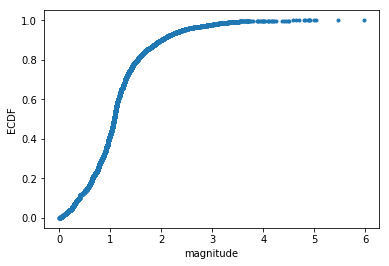

In [6]:
plt.plot(x,y,marker='.',linestyle='none')

plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.show()

The Gutenberg Richter Law states that the magnitudes of earthquakes in a given region over a given period of time are exponentially distributed.
This plot verifies gutenberg richter law and also, note the distinctive roll-off at magnitudes below 1.0.

#### Computing b value

In [7]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1d data"""
    bs_sample = np.random.choice( data, len(data) )
 
    return func(bs_sample)

In [8]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [9]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    m = mags[mags >= mt]

    b = (np.mean(m) - mt) * np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = draw_bs_reps(m, np.mean, size=n_reps)
        
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        conf_int = np.percentile(b_bs_reps, perc)
    
        return b, conf_int


The ECDF is effective at exposing roll-off, as you could see below magnitude 1. Because there are plenty of earthquakes above magnitude 3, we can use mt = 3 as your completeness threshold. With this completeness threshold,we will compute the b-value for the Parkfield region from 1950 to 2016, along with the 95% confidence interval. Print the results to the screen. The variable mags with all the magnitudes is in your namespace.
Overlaying the theoretical Exponential CDF to verify that the Parkfield region follows the Gutenberg-Richter Law.

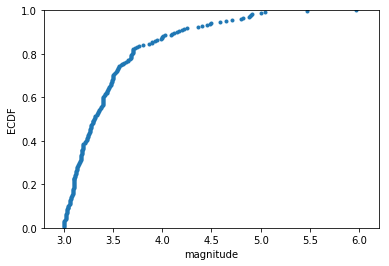

b-value: 1.08
95% conf int: [0.94, 1.24]


In [10]:
# Compute b-value and confidence interval
mt = 3
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

_ = plt.plot(ecdf(m_theor))

x1,y1 = ecdf(mags[mags >= mt])
_ = plt.plot(x1,y1, marker='.', linestyle='none')

_ = plt.xlabel('magnitude')
_ = plt.ylabel('ECDF')
_ = plt.xlim(2.8, 6.2)
_ = plt.ylim(0,1)
plt.show()

print("""b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

Parkfield seems to follow the Gutenberg-Richter law very well. The b-value of about 1 is typical for regions along fault zones.

### Timing of Earthquakes

Two models of earthquakes: 

**Exponential** : Earthquakes happen like a poissons process. It means when the next earthquake will happen has no relation with when the last earthquake had happened.

**Gaussian** : The earthquakes have well defined period.

In [11]:
data_eq['year'] = pd.DatetimeIndex(data_eq['time']).year
data_eq['month'] = pd.DatetimeIndex(data_eq['time']).month
 
mags4yr = data_eq['year'][mags>4]
mags4mn = data_eq['month'][mags>4]
gapyr = np.zeros(len(mags4yr))
gapmn = np.zeros(len(mags4yr))

for i in range(len(mags4yr)-1):
    gapyr[i] = mags4yr.iloc[i+1] - mags4yr.iloc[i]
    gapmn[i] = mags4mn.iloc[i+1] - mags4mn.iloc[i]

timegap = []
timegap = gapyr*12 + gapmn
timegap

array([  0.,  14.,  89.,   8., 205.,   6.,   7.,  13.,  95.,   0.,  22.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
         0.,   6.,   0.,  24.,  63.,   0.])

We have taken only one earthquake from one month to filter out the after shocks.

In [12]:
time_gap = timegap[timegap>0]
time_gap

array([ 14.,  89.,   8., 205.,   6.,   7.,  13.,  95.,  22.,   2.,   6.,
        24.,  63.])

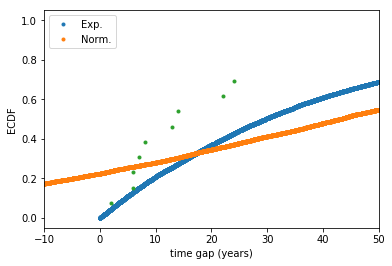

In [13]:
mean_time_gap = np.mean(time_gap)

std_time_gap = np.std(time_gap)

time_gap_exp = np.random.exponential(mean_time_gap, size=10000)

time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=10000)

xexp,yexp = ecdf(time_gap_exp)
xnorm, ynorm = ecdf(time_gap_norm)

# Plot theoretical CDFs
_ = plt.plot(xexp,yexp,marker='.',linestyle='none')
_ = plt.plot(xnorm, ynorm,marker='.',linestyle='none')

# Plot Parkfield ECDF
x2,y2 = ecdf(time_gap)
_ = plt.plot(x2,y2,marker='.',linestyle='none')

_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)
plt.show()

We took very small magnitude earthquakes, that too with very few data points which might be the reason for this fit.

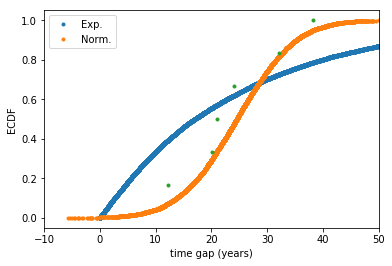

In [31]:
time_gap1 = [24.06570842, 20.07665982, 21.01848049, 12.24640657, 32.05475702,38.2532512 ]
# This is the array we get after manual removal of aftershocks
# This might have a better fit

# Compute the mean time gap: mean_time_gap
mean_time_gap1 = np.mean(time_gap1)

# Standard deviation of the time gap: std_time_gap
std_time_gap1 = np.std(time_gap1)

# Generate theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap1, size=10000)

# Generate theoretical Normal distribution of timings: time_gap_norm
time_gap_norm = np.random.normal(mean_time_gap1, std_time_gap1, size=10000)

xexp,yexp = ecdf(time_gap_exp)
xnorm, ynorm = ecdf(time_gap_norm)

# Plot theoretical CDFs
_ = plt.plot(xexp,yexp,marker='.',linestyle='none')
_ = plt.plot(xnorm, ynorm,marker='.',linestyle='none')

# Plot Parkfield ECDF
x2,y2 = ecdf(time_gap1)
_ = plt.plot(x2,y2,marker='.',linestyle='none')

_ = plt.legend(('Exp.', 'Norm.'), loc='upper left')

_ = plt.xlabel('time gap (years)')
_ = plt.ylabel('ECDF')
_ = plt.xlim(-10, 50)
plt.show()

Now it looks like normal ecdf curve gives a better fit

**When will the next big Parkfield earthquake happen?**
The last big earthquake in the Parkfield region was on the evening of September 27, 2004 local time.The task is to get an estimate as to when the next Parkfield quake will be, assuming the Exponential model and also the Gaussian model. In both cases, the best estimate is given by the mean time gap, 24.62 years, meaning that the next earthquake would be in 2029. Compute 95% confidence intervals on when the next earthquake will be assuming an Exponential distribution parametrized by mean_time_gap you computed. and the same assuming a Normal distribution parametrized by mean_time_gap and std_time_gap.

In [32]:
last_quake = 2004.74
today = 2018.81

# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap1, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap1, std_time_gap1, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)


Exponential: [2019.44711836 2035.84279232 2108.34383418]
     Normal: [2019.76449154 2030.49977059 2046.47954982]


According to the gaussian model the next parkfield EQ will occur in 2030.

This doesn't tell us anything about the applicability of the model. So lets check if the date of the last eq which came in 2004, which with our predicted EQ.

In [33]:
data_eq[mags>5]

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc,year,month
5,1966-06-28 04:26:16.260,35.790500,-120.294000,6.000,5.47,ml,15.0,247.0,1.18300,0.48,...,8.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US,1966,6
3153,2004-09-28 17:15:24.250,35.818167,-120.366000,8.136,5.97,mw,61.0,26.0,0.01622,0.04,...,4.0,reviewed,nc,nc,Shandon,California,San Luis Obispo County,US,2004,9
3810,2004-09-29 17:10:04.960,35.885502,-120.505837,-0.457,5.04,mw,158.0,161.0,NaN,0.25,...,6.0,reviewed,ci,ci,San Miguel,California,San Luis Obispo County,US,2004,9


#### Putting the last earthquake as 1966, and the current date as 2003.

In [34]:
last_quake = 1966.54
today = 2003.81

# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap1, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap1, std_time_gap1, size=100000)

# No earthquake as of today, so only keep samples that are long enough
exp_samples = exp_samples[exp_samples > today - last_quake]
norm_samples = norm_samples[norm_samples > today - last_quake]

conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5]) + last_quake
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) + last_quake

print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)


Exponential: [2004.40556253 2020.76274581 2095.12355248]
     Normal: [2003.91613547 2006.62307593 2015.94536482]


**In the normal distribution the earthquake is suppose to happen in 2006, and the actual earthquake did happen in 2004, so the normal distribution did predict the earthquake. The actual date lies in the 95% interval of the predicted date.**

Also notice the size of intervals we get in normal and exponential distributions. The size of the interval in case of exponential distribution is very large.

------------------------------------------------------------

### The Kolmogorov-Smirnov test

The ECDF is formally defined as ECDF(x) = (number of samples ≤ x) / (total number of samples). 

In [35]:
def ecdf_formal(x, data):
    return np.searchsorted(np.sort(data), x, side='right') / len(data)


# def ecdf_formal(x, data):
#     output = np.empty(len(x))

#     data = np.sort(data)

#     for i, x_val in x:
#         j = 0
#         while j < len(data) and x_val >= data[j]:
#             j += 1

#         output[i] = j

#     return output / len(data)

In [36]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x, y = ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1/len(data1)

    return np.max((D_top, D_bottom))

In [37]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    reps = np.empty(n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = ks_stat(x_samp, x_f)

    return reps

In [38]:
# Draw target distribution
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute K-S stat: d
d = ks_stat(time_gap1, x_f)

# Draw K-S replicates: reps
reps = draw_ks_reps(len(time_gap1), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

p_val = np.sum(reps >= d) / 10000
print('p =', p_val)

p = 0.2384


That's a p-value above 0.44 for the time gap we calculated by considering one EQ in month to filter out the After-shocks, but when we use the time gap array in which the after-shocks were manually removed we get a p-value of 0.22. This means that the Parkfield sequence is not outside the realm of possibility if earthquakes there are a Poisson process. This does not mean that they are generated by a Poisson process, but that the observed sequence is not incongruous with that model. The upshot is that it is really hard to say when the next Parkfield quake will be.